# Train nw2vec with the original VGAE architecture for Cora embeddings + an intermediate layer in decoding

In [1]:
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import contextlib

import numpy as np
import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import layers
from nw2vec import ae
from nw2vec import utils
from nw2vec import batching
import settings

from gae.input_data import load_data
from gae.preprocessing import sparse_to_tuple, mask_test_edges

Using TensorFlow backend.


In [2]:
@contextlib.contextmanager
def gae_directory():
    working_directory = os.path.abspath(os.curdir)
    try:
        # Move to the GAE directory
        os.chdir('../../gae')
        yield
    finally:
        # Move back
        os.chdir(working_directory)

In [3]:
# Load data
with gae_directory():
    adj, features = load_data('cora')
    features = features.toarray()

adj_train = mask_test_edges(adj)[0]
assert adj_train.diagonal().sum() == 0

In [4]:
dims = (features.shape[1], 32, 16)
n_ξ_samples =1

In [5]:
def build_q(dims, use_bias=False):
    dim_data, dim_l1, dim_ξ = dims

    q_input = keras.layers.Input(shape=(dim_data,), name='q_input')
    q_layer1_placeholders, q_layer1 = ae.gc_layer_with_placeholders(
        dim_l1, 'q_layer1', {'use_bias': use_bias, 'activation': 'relu'}, q_input)
    q_μ_flat_placeholders, q_μ_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_mu_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_logD_flat_placeholders, q_logD_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_logD_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_μlogD_flat = keras.layers.Concatenate(name='q_mulogD_flat')(
        [q_μ_flat, q_logD_flat])
    q_model = ae.Model(inputs=([q_input]
                               + q_layer1_placeholders
                               + q_μ_flat_placeholders
                               + q_logD_flat_placeholders),
                       outputs=q_μlogD_flat)

    return q_model, ('OrthogonalGaussian',)

q_model, q_codecs = build_q(dims)

def p_builder(p_input, use_bias=False):
    p_layer1 = keras.layers.Dense(dims[1], use_bias=use_bias, activation='relu',
                                  kernel_regularizer='l2', bias_regularizer='l2',
                                  name='p_layer1')(p_input)
    p_adj = layers.Bilinear(0, use_bias=False, fixed_kernel=np.eye(dims[-2]),
                            #kernel_regularizer='l2', bias_regularizer='l2',
                            name='p_adj')([p_layer1, p_layer1])
    #p_v = keras.layers.Dense(dim_data, use_bias=use_bias,
    #                         kernel_regularizer='l2', bias_regularizer='l2',
    #                         name='p_v')(p_layer1)
    #return ([p_adj, p_v], ('SigmoidBernoulliScaledAdjacency', 'SigmoidBernoulli'))
    return ([p_adj], ('SigmoidBernoulliScaledAdjacency',))

vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [1.0, 1.0]
)

In [6]:
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1),  # ignored
        utils.expand_dims_tile(
            utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]),
                                   0, n_ξ_samples),
            0, 1
        )
    ]

In [7]:
seeds_per_batch = features.shape[0]
steps_per_epoch = 1
n_epochs = 200

history = vae.fit_generator_feed(
    batching.batches(vae, adj_train, features, target_func,
                     seeds_per_batch, 1,
                     p=1, q=1, neighbour_samples=None),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    check_array_lengths=False,
    shuffle=False,
    verbose=0,
    callbacks=[
        TQDMCallback(show_inner=False),
    ]
)


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [8]:
history = {'history': history.history}

## Results

In [9]:
import matplotlib.pyplot as plt

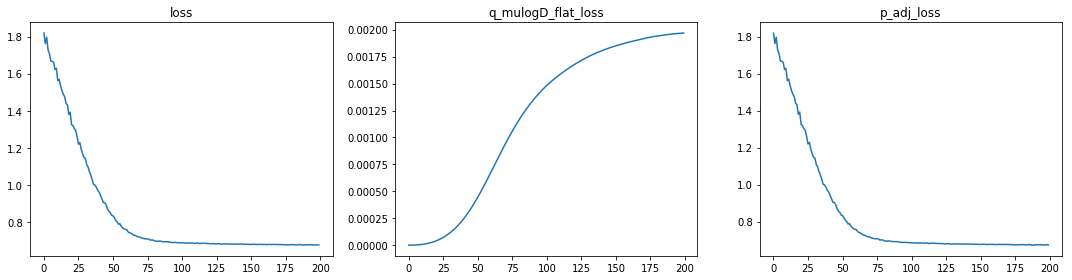

In [10]:
fig, axes = plt.subplots(1, len(history['history']), figsize=(len(history['history']) * 5, 4))
for i, (title, values) in enumerate(history['history'].items()):
    axes[i].plot(np.array(values) / features.shape[0])
    axes[i].set_title(title)
fig.tight_layout()

## Plot the embeddings

In [11]:
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import seaborn as sb

from sklearn.manifold import MDS

In [12]:
x, _, feeds = next(batching.batches(vae, adj_train, features, target_func,
                                    features.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))

q_preds, adj_preds = zip(*[vae.predict_on_fed_batch(x, feeds=feeds) for _ in range(10)])

q_preds = np.array(q_preds)
adj_preds = np.array(adj_preds)

q_pred = q_preds.mean(0)
adj_pred = scipy.special.expit(adj_preds[:, 0, :, :, :]).mean(1).mean(0)

In [13]:
# Downscale the embeddings
mds = MDS(n_jobs=-2, )
mds.fit(q_pred[:, :dims[-1]].astype(np.float64))

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-2, random_state=None, verbose=0)

In [14]:
# Load the ground truth labels

def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

with gae_directory():
    ty = pickle.load(open("data/ind.cora.ty", 'rb'), encoding='latin1')
    ally = pickle.load(open("data/ind.cora.ally", 'rb'), encoding='latin1')
    test_idx_reorder = parse_index_file("data/ind.cora.test.index")
test_idx_range = np.sort(test_idx_reorder)

labels = sp.vstack((ally, ty)).toarray()
labels[test_idx_reorder, :] = labels[test_idx_range, :]

In [15]:
# Turn labels into colors
palette = sb.color_palette(n_colors=labels.shape[1])
colors = np.array(palette)[np.argmax(labels, axis=1)]

[(-3, 4), (-0.5, 0.5)]

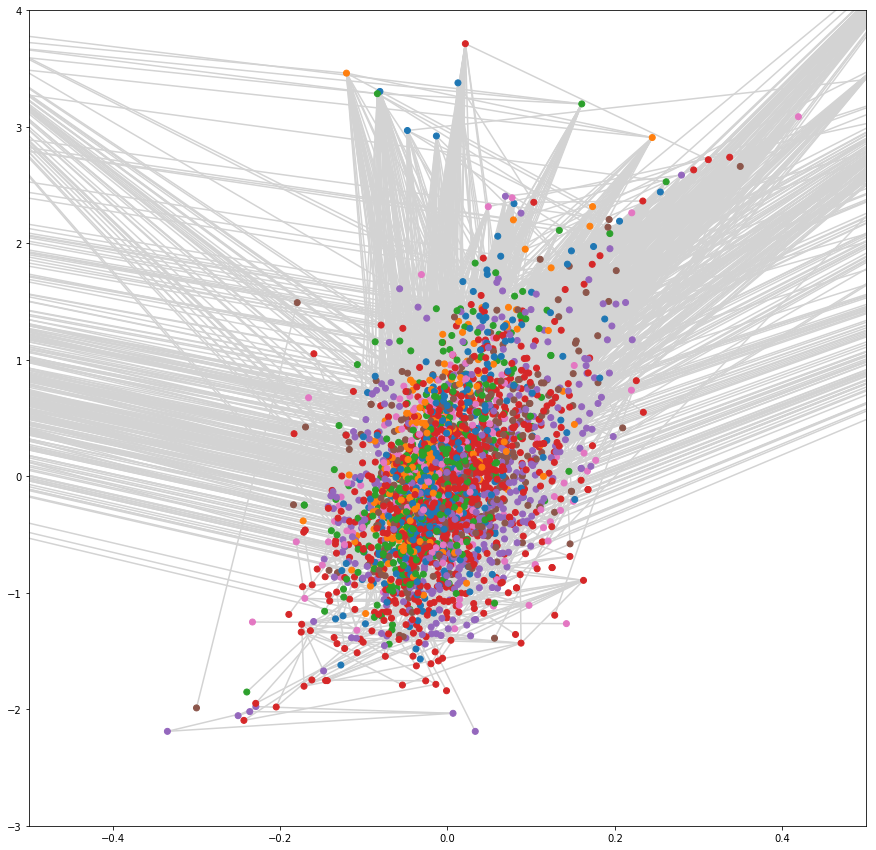

In [18]:
# Plot the downscaled embeddings and the links
fig, ax = plt.subplots(figsize=(15, 15))
edges = np.array([[mds.embedding_[i], mds.embedding_[j]] for (i, j) in sparse_to_tuple(sp.triu(adj))[0]])
edges = edges.transpose([2, 1, 0])
ax.plot(edges[0], edges[1], color='lightgrey', zorder=1)
ax.scatter(mds.embedding_[:, 0], mds.embedding_[:, 1], c=colors, zorder=2)
ax.set(xlim=(-.5, .5), ylim=(-3, 4))